In [3]:
!pip install pandas matplotlib prophet


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Data fields:

instant: record index
dteday : date
season : season (1:winter, 2:spring, 3:summer, 4:fall)
yr : year (0: 2011, 1:2012)
mnth : month ( 1 to 12)
hr : hour (0 to 23)
holiday : weather day is holiday or not (extracted from [Web Link])
weekday : day of the week
workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
weathersit :
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
hum: Normalized humidity. The values are divided to 100 (max)
windspeed: Normalized wind speed. The values are divided to 67 (max)
casual: count of casual users
registered: count of registered users
cnt: count of total rental bikes including both casual and registered

In [82]:
import pandas as pd

df = pd.read_csv("hour.csv")
df.head(12)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [84]:
# Rename columns
df = df.rename(columns={'dteday':'ds', 'cnt':'y'})

# Convert date
df['ds'] = pd.to_datetime(df['ds'])


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   ds          17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  y           17379 non-

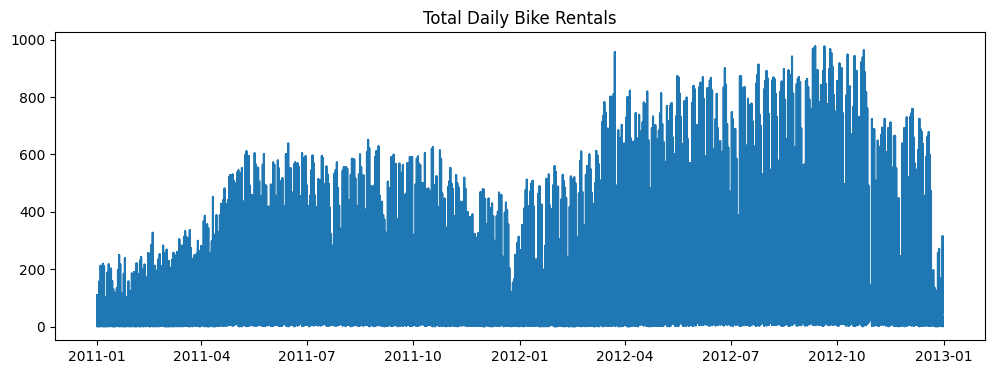

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df['ds'], df['y'])
plt.title("Total Daily Bike Rentals")
plt.show()



In [88]:
df['weekday'] = df['ds'].dt.day_name()
df.groupby('weekday')['y'].mean()


weekday
Friday       196.135907
Monday       183.744655
Saturday     190.209793
Sunday       177.468825
Thursday     196.436665
Tuesday      191.238891
Wednesday    191.130505
Name: y, dtype: float64

In [89]:
print(df.columns)

Index(['instant', 'ds', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'y'],
      dtype='object')


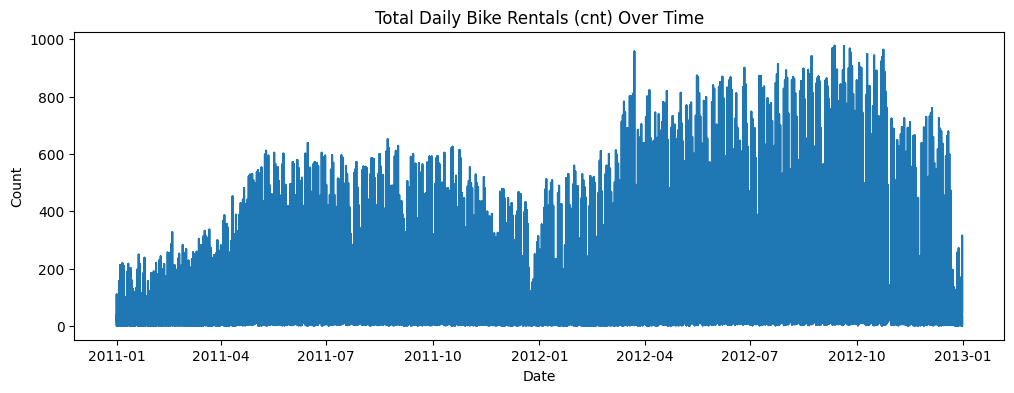

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df['ds'], df['y'])
plt.title("Total Daily Bike Rentals (cnt) Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()


In [91]:
print(df.columns)

Index(['instant', 'ds', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'y'],
      dtype='object')


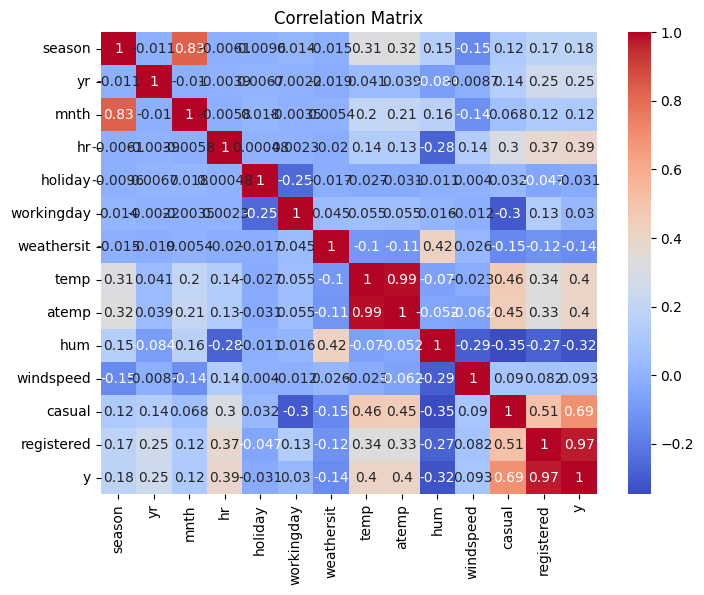

In [92]:
numerical_features = ['season', 'yr', 'mnth', 'hr', 'holiday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'y']
corr = df[numerical_features].corr()

import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


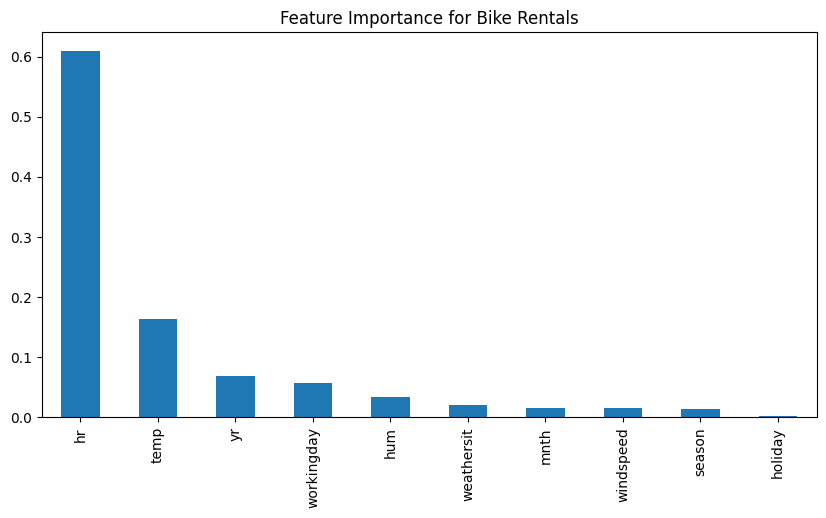

In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# [ 'ds', 'season', 'yr', 'mnth', 'hr', 'holiday',
#        'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
#        'casual', 'registered', 'y']

features = ['season','yr','mnth','hr','holiday','workingday','weathersit','temp','hum','windspeed']
X = df[features]
y = df['y']

# Split for quick evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
importance.plot(kind='bar', figsize=(10,5), title='Feature Importance for Bike Rentals')
plt.show()


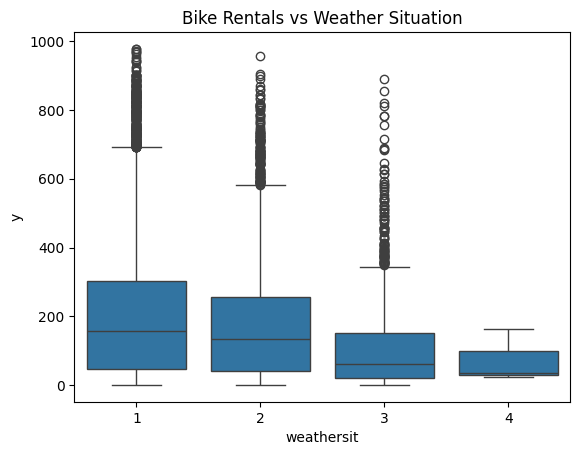

In [94]:
sns.boxplot(x='weathersit', y='y', data=df)
plt.title("Bike Rentals vs Weather Situation")
plt.show()


In [95]:
print(df.columns)

Index(['instant', 'ds', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'y'],
      dtype='object')


In [96]:
from sklearn.preprocessing import LabelEncoder

df['y_lag1'] = df['y'].shift(1)
df['y_lag7'] = df['y'].shift(7)
df['y_roll7'] = df['y'].rolling(7).mean()
df['dayofweek'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month
df = df.dropna()  # drop initial rows with NaN

#Label Encode Weekday
le = LabelEncoder()
df['weekday'] = le.fit_transform(df['weekday'])

# Define a function to determine if a given hour is typically a rush hour
def is_rush_hour(hour):
    if (7 <= hour <= 9) or (16 <= hour <= 19):
        return 1
    else:
        return 0

# Apply the function to the 'hr' column to create the new 'rush_hour' feature
df['rush_hour'] = df['hr'].apply(is_rush_hour)

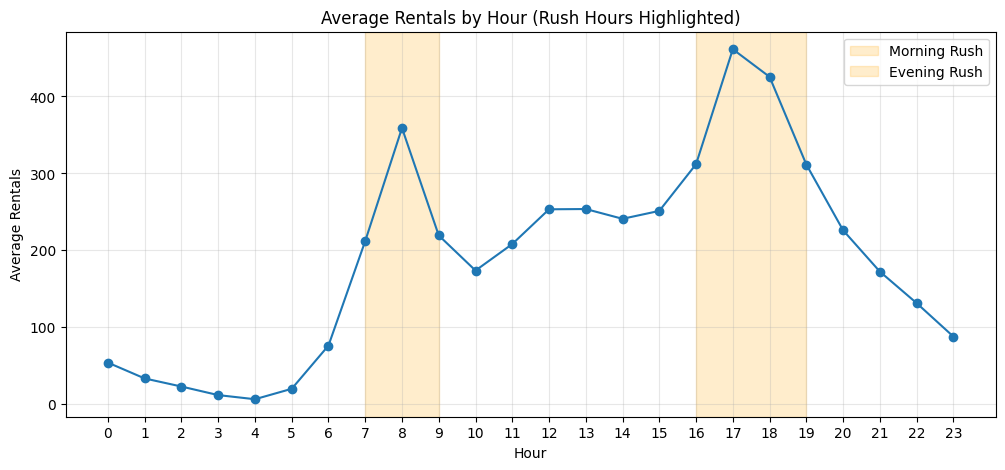

In [97]:
import matplotlib.pyplot as plt

hourly_mean = df.groupby('hr')['y'].mean()

plt.figure(figsize=(12,5))
plt.plot(hourly_mean.index, hourly_mean.values, marker='o')
plt.axvspan(7, 9, color='orange', alpha=0.2, label='Morning Rush')
plt.axvspan(16, 19, color='orange', alpha=0.2, label='Evening Rush')
plt.title("Average Rentals by Hour (Rush Hours Highlighted)")
plt.xlabel("Hour")
plt.ylabel("Average Rentals")
plt.xticks(range(0,24))
plt.legend()
plt.grid(alpha=0.3)
plt.show()


11:09:03 - cmdstanpy - INFO - Chain [1] start processing
11:09:06 - cmdstanpy - INFO - Chain [1] done processing


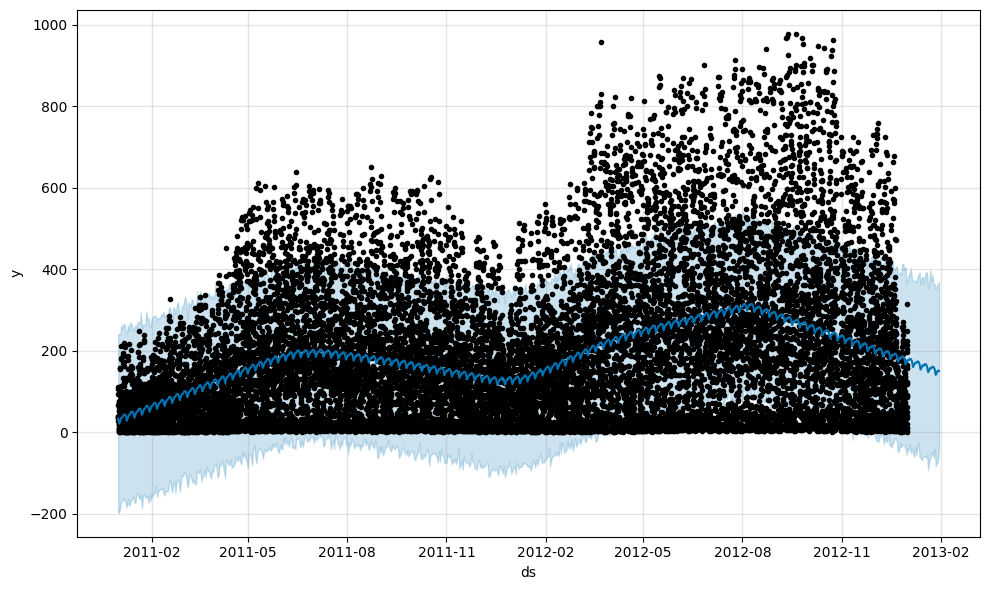

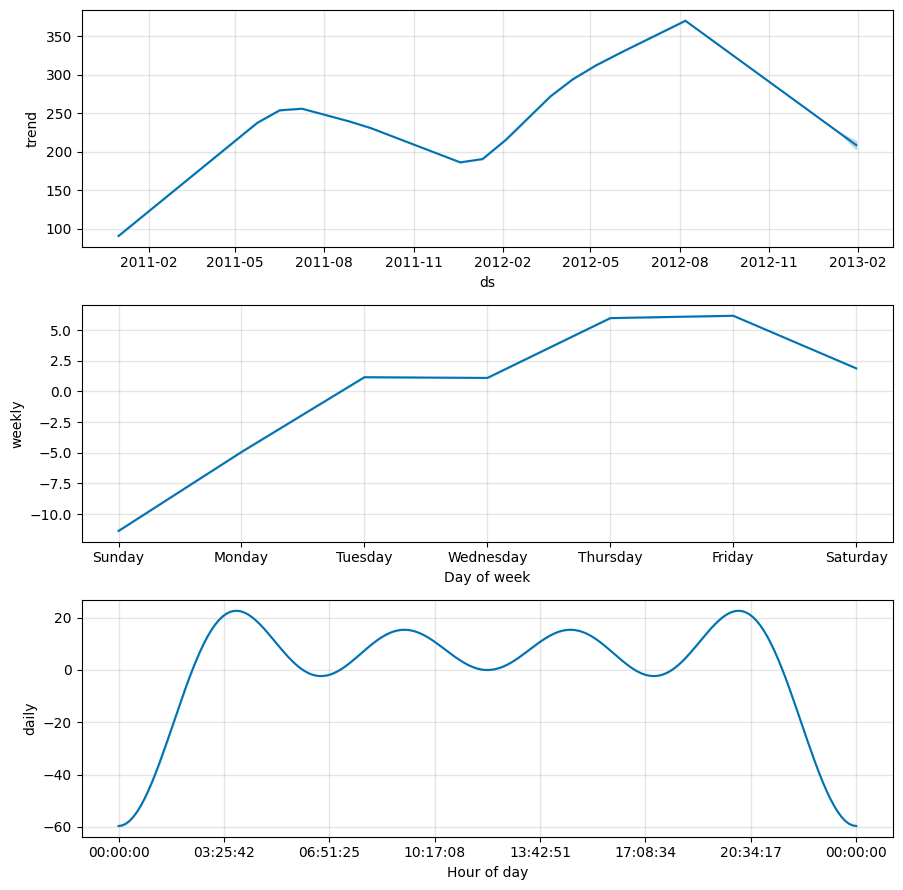

  0%|          | 0/4 [00:00<?, ?it/s]11:09:06 - cmdstanpy - INFO - Chain [1] start processing
11:09:08 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:05,  1.75s/it]11:09:08 - cmdstanpy - INFO - Chain [1] start processing
11:09:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:03,  1.89s/it]11:09:10 - cmdstanpy - INFO - Chain [1] start processing
11:09:12 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:05<00:01,  1.93s/it]11:09:12 - cmdstanpy - INFO - Chain [1] start processing
11:09:14 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


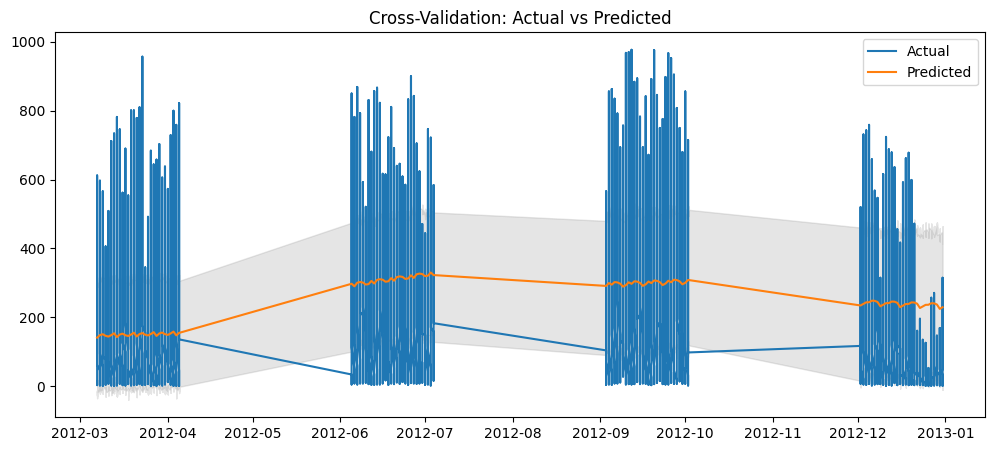

In [65]:
from prophet import Prophet



model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=False,
    daily_seasonality=True
)


model.fit(df)

future = model.make_future_dataframe(periods=30)  # predict next 30 days
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Forecast plot
model.plot(forecast)
plt.show()

# Components plot
model.plot_components(forecast)
plt.show()

from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='365 days', period='90 days', horizon='30 days')
performance_metrics(df_cv)

import matplotlib.pyplot as plt

df_cv.set_index('ds', inplace=True)
plt.figure(figsize=(12,5))
plt.plot(df_cv['y'], label='Actual')
plt.plot(df_cv['yhat'], label='Predicted')
plt.fill_between(df_cv.index, df_cv['yhat_lower'], df_cv['yhat_upper'], color='gray', alpha=0.2)
plt.legend()
plt.title("Cross-Validation: Actual vs Predicted")
plt.show()

In [70]:
print(df.columns)

Index(['instant', 'ds', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'y', 'y_lag1', 'y_lag7', 'y_roll7', 'dayofweek',
       'month', 'rush_hour'],
      dtype='object')


RMSE: 72.87, MAE: 48.15


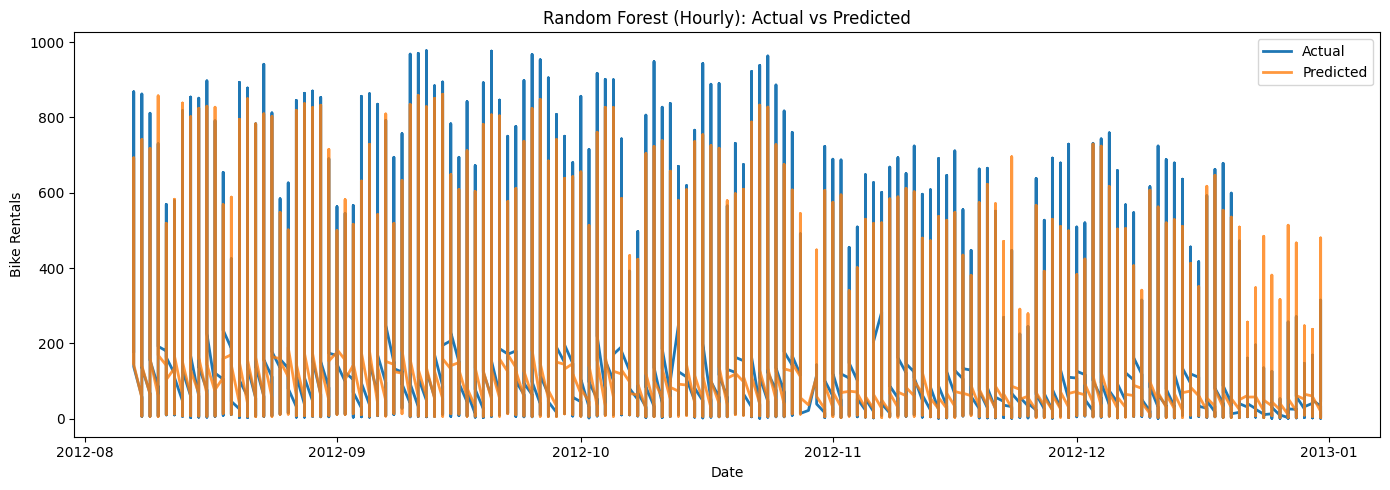

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Features & target

# Split 80% train, 20% test
split_idx = int(len(df)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Plot
# plt.figure(figsize=(12,5))
# plt.plot(df['ds'][split_idx:], y_test, label='Actual')
# plt.plot(df['ds'][split_idx:], y_pred, label='Predicted')
# plt.legend()
# plt.title("Random Forest: Actual vs Predicted")
# plt.show()

plt.figure(figsize=(14,5))

plt.plot(
    df.loc[y_test.index, 'ds'],
    y_test,
    label='Actual',
    linewidth=2
)

plt.plot(
    df.loc[y_test.index, 'ds'],
    y_pred,
    label='Predicted',
    linewidth=2,
    alpha=0.8
)

plt.legend()
plt.title("Random Forest (Hourly): Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Bike Rentals")
plt.tight_layout()
plt.show()



Fitting 3 folds for each of 108 candidates, totalling 324 fits


c:\Users\TechnoNext\Downloads\Forcasting\myvenv\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
162 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
77 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\TechnoNext\Downloads\Forcasting\myvenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\TechnoNext\Downloads\Forcasting\myvenv\Lib\site-packages\sklearn\base.py", line 1329, in wrapper
    estimator._validate_params()
  File "c:\Users\TechnoNext\Downloads\Forcasting\myvenv\Lib\site-packages\sklearn\base.py", line 492, in _validate_

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
RMSE: 98.18, MAE: 65.60


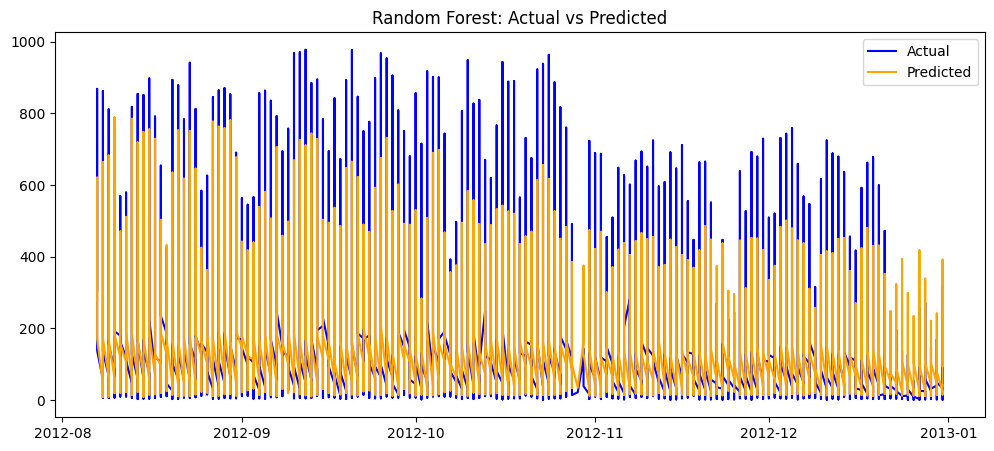

In [74]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ---------------------------
# Prepare features
# ---------------------------
# df = df_prophet.copy()  # your dataframe
# TARGET = 'y'

# # Create time-based features
# df['month'] = df['ds'].dt.month
# df['day_of_week'] = df['ds'].dt.dayofweek
# df['day_of_month'] = df['ds'].dt.day
# df['week_of_year'] = df['ds'].dt.isocalendar().week
# df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

# # Create lag features
# for lag in [1, 7, 14]:
#     df[f'y_lag_{lag}'] = df[TARGET].shift(lag)

# # Create rolling mean features
# for window in [7, 14]:
#     df[f'y_roll_{window}'] = df[TARGET].shift(1).rolling(window).mean()

# # Drop rows with NaN (due to lag/rolling)
# df.dropna(inplace=True)

# # Define features
# features = ['temp', 'atemp', 'yr', 'hum', 'month', 'day_of_week', 
#             'day_of_month', 'week_of_year', 'is_weekend', 
#             'y_lag_1', 'y_lag_7', 'y_lag_14', 'y_roll_7', 'y_roll_14']

# X = df[features]
# y = df[TARGET]

# Train-test split (80-20)
split_idx = int(len(df)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ---------------------------
# Hyperparameter tuning
# ---------------------------
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt']
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), 
                       param_grid, cv=3, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# ---------------------------
# Predict and evaluate
# ---------------------------
y_pred = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Best Parameters: {grid_rf.best_params_}")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# ---------------------------
# Plot results
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(df['ds'][split_idx:], y_test, label='Actual', color='blue')
plt.plot(df['ds'][split_idx:], y_pred, label='Predicted', color='orange')
plt.legend()
plt.title("Random Forest: Actual vs Predicted")
plt.show()


In [ ]:
df_prophet.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y
0,1,2018-01-01,1,0,1,0,Monday,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,1,0,1,0,Tuesday,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,1,0,1,0,Wednesday,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-01-04,1,0,1,0,Thursday,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-01-05,1,0,1,0,Friday,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['weekday'] = le.fit_transform(df['weekday'])
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Friday': np.int64(0), 'Monday': np.int64(1), 'Saturday': np.int64(2), 'Sunday': np.int64(3), 'Thursday': np.int64(4), 'Tuesday': np.int64(5), 'Wednesday': np.int64(6)}


RMSE: 98.18
MSE: 9640.23
MAE: 65.60
Median AE: 38.82
R-squared: 0.802
Explained Variance: 0.807
MAPE: 67.26%
sMAPE: 37.79%
MASE: 1.095
Forecast Bias: -16.56


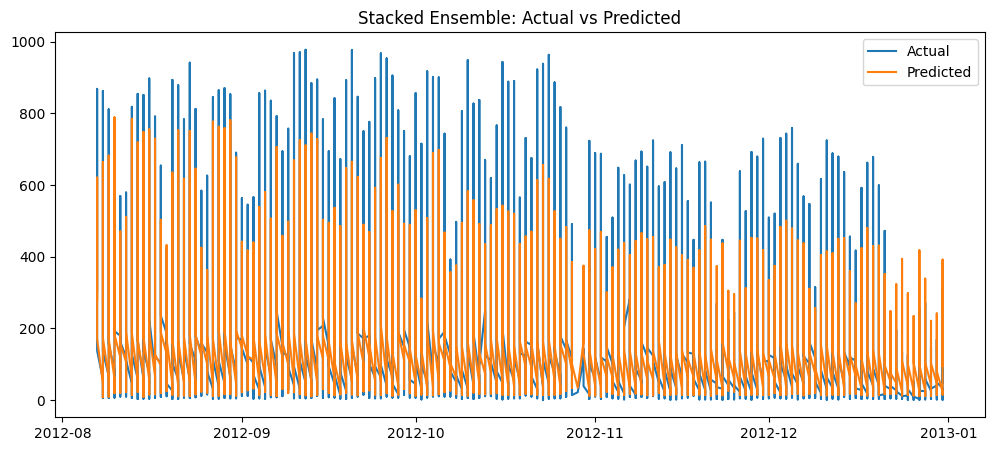

In [76]:
# Imports

import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# --- Feature Engineering ---
# df = df_prophet.copy()
# df['y_lag1'] = df['y'].shift(1)
# df['y_lag7'] = df['y'].shift(7)
# df['y_roll7'] = df['y'].rolling(7).mean()
# df['dayofweek'] = df['ds'].dt.dayofweek
# df['month'] = df['ds'].dt.month
# df = df.dropna()  # drop initial rows with NaN

# #Label Encode Weekday
# le = LabelEncoder()
# df['weekday'] = le.fit_transform(df['weekday'])

# # Features and target
# features = ['season','holiday','weekday','workingday','weathersit','windspeed',,'temp','atemp','yr','hum','y_lag1','y_lag7','y_roll7','dayofweek','month']
# X = df[features]
# y = df['y']

# Train-test split
split_idx = int(len(df)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- Random Forest Hyperparameter Tuning ---
rf_params = {
    'n_estimators':[300],
    'max_depth':[10],
    'min_samples_split':[10],
    'min_samples_leaf':[1],
    'max_features':['sqrt']
}
rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, n_jobs=-1)
rf.fit(X_train, y_train)

# --- XGBoost Hyperparameter Tuning ---
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {
    'n_estimators':[300],
    'max_depth':[6,8,10],
    'learning_rate':[0.05,0.1],
    'subsample':[0.8,1],
    'colsample_bytree':[0.8,1]
}
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# --- Stacking Ensemble ---
estimators = [
    ('rf', rf.best_estimator_),
    ('xgb', xgb_grid.best_estimator_)
]
stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), n_jobs=-1)
stack.fit(X_train, y_train)

# --- Predictions & Metrics ---

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
med_ae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
bias = np.mean(y_pred - y_test)

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape_val = smape(y_test.values, y_pred)

def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.sum(np.abs(np.diff(y_train))) / n  # mean absolute difference of naive forecast
    errors = np.abs(y_true - y_pred)
    return np.mean(errors / d)

mase_val = mase(y_test.values, y_pred, y_train.values)

print(f"RMSE: {rmse:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Median AE: {med_ae:.2f}")
print(f"R-squared: {r2:.3f}")
print(f"Explained Variance: {evs:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"sMAPE: {smape_val:.2f}%")
print(f"MASE: {mase_val:.3f}")
print(f"Forecast Bias: {bias:.2f}")


# --- Plot ---
residuals = y_test - y_pred

# plt.figure(figsize=(12,5))
# plt.plot(df['ds'][split_idx:], residuals)
# plt.axhline(0, color='red', linestyle='--')
# plt.title("Residuals over Time")
# plt.show()

# window = 30  # 30-day rolling error
# rolling_rmse = np.sqrt((residuals**2).rolling(window=window).mean())
# rolling_mae = residuals.abs().rolling(window=window).mean()

# plt.figure(figsize=(12,5))
# plt.plot(df['ds'][split_idx:], rolling_rmse, label='Rolling RMSE')
# plt.plot(df['ds'][split_idx:], rolling_mae, label='Rolling MAE')
# plt.legend()
# plt.title("Rolling Error Metrics")
# plt.show()


plt.figure(figsize=(12,5))
plt.plot(df['ds'][split_idx:], y_test, label='Actual')
plt.plot(df['ds'][split_idx:], y_pred, label='Predicted')
plt.legend()
plt.title("Stacked Ensemble: Actual vs Predicted")
plt.show()


           ds       y_pred
0  2020-01-01  1847.971546
1  2020-01-02  1824.159930
2  2020-01-03  1835.487726
3  2020-01-04  2152.663413
4  2020-01-05  1837.983032
5  2020-01-06  1632.633132
6  2020-01-07  1840.295063
7  2020-01-08  1703.353301
8  2020-01-09  1734.298627
9  2020-01-10  1737.552963
10 2020-01-11  1850.471928
11 2020-01-12  1810.374882
12 2020-01-13  1642.003676
13 2020-01-14  1621.398619
14 2020-01-15  1773.647938
15 2020-01-16  1770.893688
16 2020-01-17  1744.046996
17 2020-01-18  1756.008608
18 2020-01-19  1822.093702
19 2020-01-20  1687.506999
20 2020-01-21  1675.763486
21 2020-01-22  1675.725338
22 2020-01-23  1770.999267
23 2020-01-24  1776.240568
24 2020-01-25  1784.844225
25 2020-01-26  1791.244683
26 2020-01-27  1674.174831
27 2020-01-28  1677.542997
28 2020-01-29  1725.172158
29 2020-01-30  1733.886468


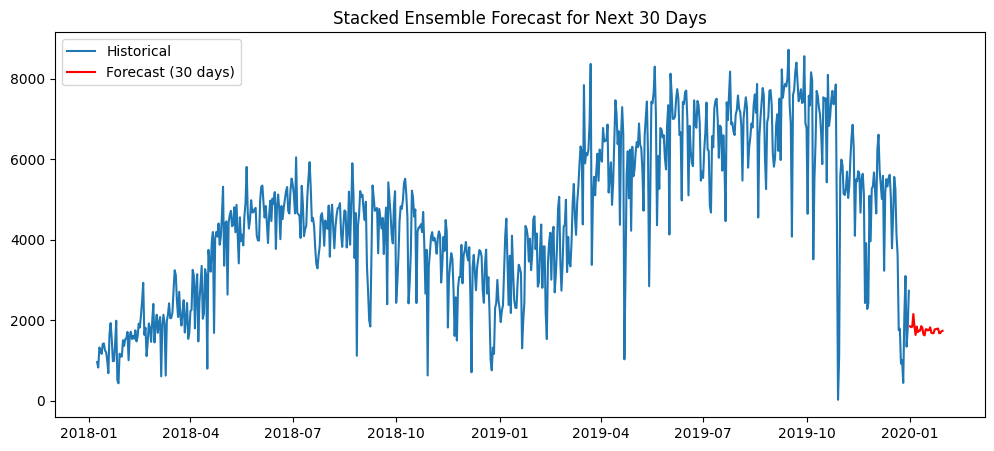

In [ ]:

import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# --- Assume df_prophet is your original DataFrame ---
df = df_prophet.copy()

# --- Feature Engineering for training ---
df['y_lag1'] = df['y'].shift(1)
df['y_lag7'] = df['y'].shift(7)
df['y_roll7'] = df['y'].rolling(7).mean()
df['dayofweek'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month
df = df.dropna()

# --- Features & target ---
features = [
    'season', 'holiday', 'workingday', 'weathersit',
    'temp', 'atemp', 'hum', 'windspeed',
    'yr', 'dayofweek', 'month',
    'y_lag1', 'y_lag7', 'y_roll7'
]
X = df[features]
y = df['y']

# --- Train-test split ---
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- Random Forest & XGBoost training (GridSearch) ---
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

rf_params = {'n_estimators':[300], 'max_depth':[10], 'min_samples_split':[10], 'min_samples_leaf':[1], 'max_features':['sqrt']}
rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, n_jobs=-1)
rf.fit(X_train, y_train)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {'n_estimators':[300],'max_depth':[6,8,10],'learning_rate':[0.05,0.1],'subsample':[0.8,1],'colsample_bytree':[0.8,1]}
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# --- Stacking Ensemble ---
estimators = [('rf', rf.best_estimator_), ('xgb', xgb_grid.best_estimator_)]
stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), n_jobs=-1)
stack.fit(X_train, y_train)

# --- Recursive Forecast for Next 30 Days ---
future_days = 30
last_date = df['ds'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)
future_preds = []

# Copy last 7 days of y for lag calculations
last_7_y = df['y'].iloc[-7:].tolist()

for i in range(future_days):
    row = {}
    date = future_dates[i]
    
    # Calendar features
    row['dayofweek'] = date.dayofweek
    row['month'] = date.month
    
    # Use last available weather info (replace with forecast if available)
    row['season'] = df['season'].iloc[-1]
    row['holiday'] = df['holiday'].iloc[-1]
    row['workingday'] = df['workingday'].iloc[-1]
    row['weathersit'] = df['weathersit'].iloc[-1]
    row['temp'] = df['temp'].iloc[-1]
    row['atemp'] = df['atemp'].iloc[-1]
    row['hum'] = df['hum'].iloc[-1]
    row['windspeed'] = df['windspeed'].iloc[-1]
    row['yr'] = df['yr'].iloc[-1]
    
    # Lag features
    row['y_lag1'] = last_7_y[-1]
    row['y_lag7'] = last_7_y[0]
    row['y_roll7'] = np.mean(last_7_y)
    
    # Predict

    row_df = pd.DataFrame([row])[features]  # ensure same order

    y_pred = stack.predict(row_df)[0]
    future_preds.append(y_pred)
    
    # Update last_7_y for next iteration
    last_7_y.pop(0)
    last_7_y.append(y_pred)

# --- Combine predictions with dates ---
future_df = pd.DataFrame({'ds': future_dates, 'y_pred': future_preds})
print(future_df)

# --- Optional: plot the forecast ---
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(df['ds'], df['y'], label='Historical')
plt.plot(future_df['ds'], future_df['y_pred'], label='Forecast (30 days)', color='red')
plt.legend()
plt.title("Stacked Ensemble Forecast for Next 30 Days")
plt.show()


XGBoost RMSE: 1480.42, MAE: 1258.16


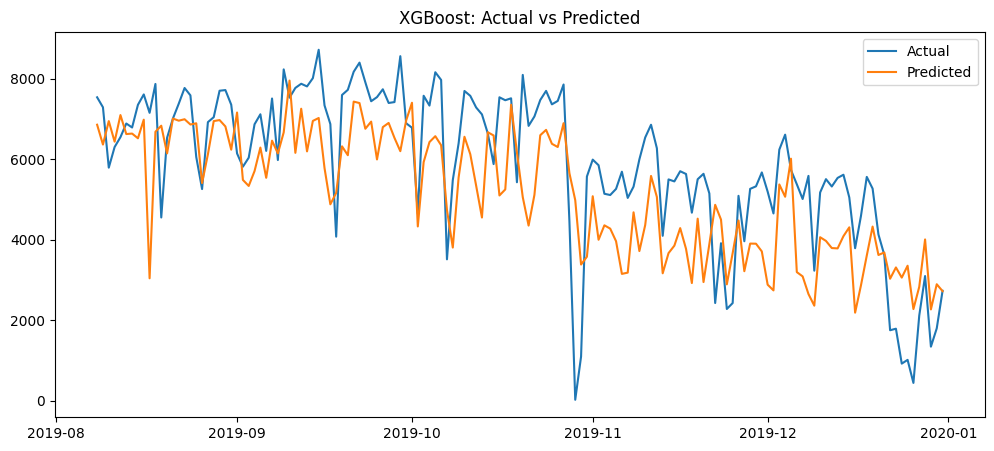

In [ ]:
import xgboost as xgb

# Convert to DMatrix if needed or use sklearn API
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
xgbr.fit(X_train, y_train)

# Predict
y_pred_xgb = xgbr.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Plot
plt.figure(figsize=(12,5))
plt.plot(df_prophet['ds'][split_idx:], y_test, label='Actual')
plt.plot(df_prophet['ds'][split_idx:], y_pred_xgb, label='Predicted')
plt.legend()
plt.title("XGBoost: Actual vs Predicted")
plt.show()


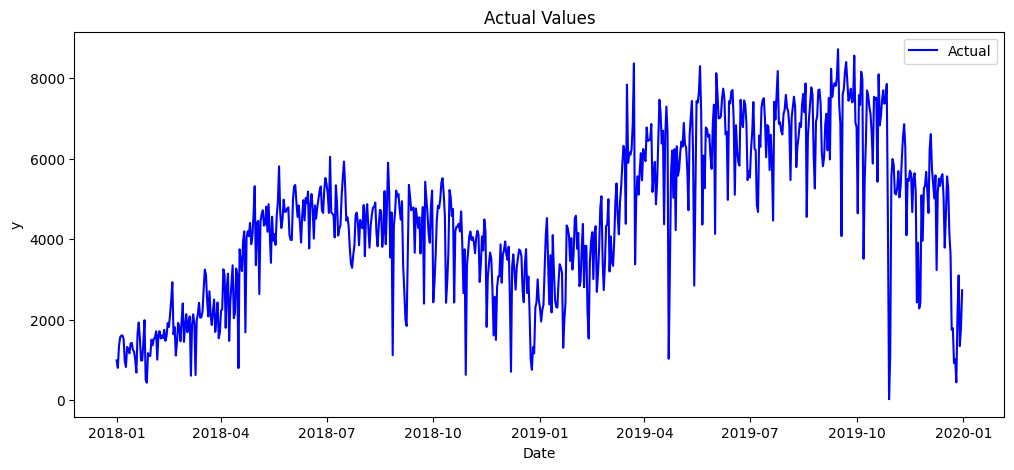

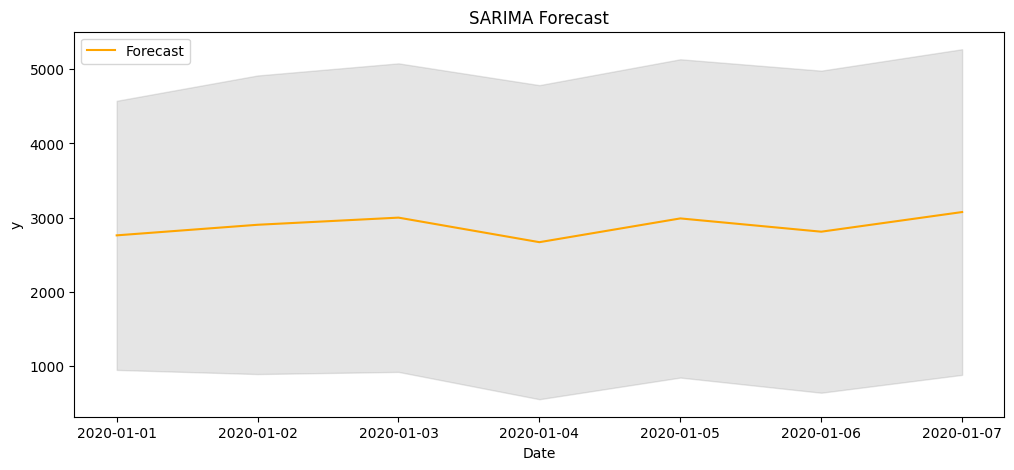

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA (order=(p,d,q), seasonal_order=(P,D,Q,s))
model = SARIMAX(df_prophet['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

# Forecast next 7 days
forecast = model_fit.get_forecast(steps=7)
forecast_df = forecast.summary_frame()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual', color='blue')
plt.title("Actual Values")
plt.xlabel("Date")
plt.ylabel("y")
plt.legend()
plt.show()


# Make sure forecast_df has 'ds', 'mean', 'mean_ci_lower', 'mean_ci_upper'
forecast_dates = pd.date_range(start=df_prophet['ds'].iloc[-1] + pd.Timedelta(days=1), periods=7)
forecast_df['ds'] = forecast_dates

plt.figure(figsize=(12,5))
plt.plot(forecast_df['ds'], forecast_df['mean'], label='Forecast', color='orange')
plt.fill_between(forecast_df['ds'], 
                 forecast_df['mean_ci_lower'], 
                 forecast_df['mean_ci_upper'], 
                 color='gray', alpha=0.2)
plt.title("SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("y")
plt.legend()
plt.show()


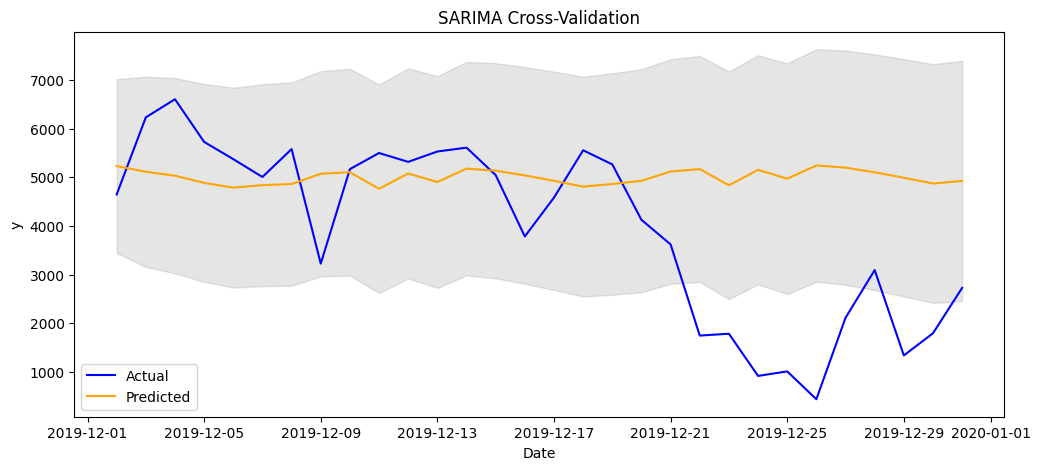

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split data: last 30 days as test
train = df_prophet[:-30]
test = df_prophet[-30:]

# Fit SARIMA on training data
model = SARIMAX(train['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

# Forecast the test period
forecast = model_fit.get_forecast(steps=len(test))
forecast_df = forecast.summary_frame()

# Add dates for plotting
forecast_df['ds'] = test['ds'].values

# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(test['ds'], test['y'], label='Actual', color='blue')
plt.plot(forecast_df['ds'], forecast_df['mean'], label='Predicted', color='orange')
plt.fill_between(forecast_df['ds'], 
                 forecast_df['mean_ci_lower'], 
                 forecast_df['mean_ci_upper'], 
                 color='gray', alpha=0.2)
plt.title("SARIMA Cross-Validation")
plt.xlabel("Date")
plt.ylabel("y")
plt.legend()
plt.show()


In [ ]:
print(df_prophet.columns)


Index(['instant', 'ds', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'y'],
      dtype='object')


Epoch 1/150


c:\Users\TechnoNext\Downloads\Forcasting\myvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0828 - val_loss: 0.0326
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - val_loss: 0.0363
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.0378
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - val_loss: 0.0356
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - val_loss: 0.0311
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - val_loss: 0.0298
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 - val_loss: 0.0299
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0115 - val_loss: 0.0292
Epoch 9/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0125 - val_loss: 0.0331
Epoch 10/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 - val_loss: 0.0305
Epoch 11/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - val_loss: 0.0299
Epoch 12/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116 - val_lo

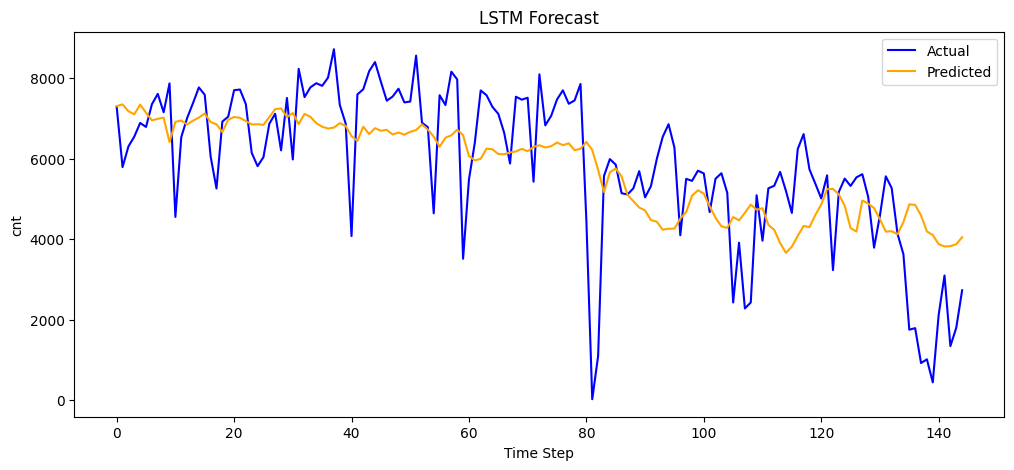

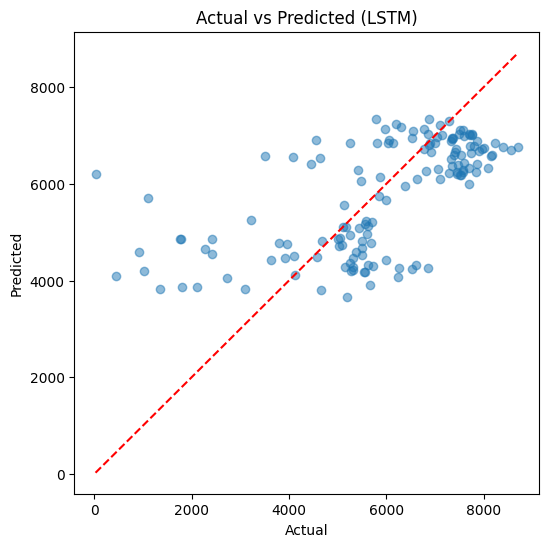

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Prepare data
# -----------------------------
features = ['temp', 'atemp', 'yr', 'hum']
target = 'y'

X = df_prophet[features].values
y = df_prophet[target].values.reshape(-1,1)

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Convert to sequences for LSTM
def create_sequences(X, y, time_steps=7):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

time_steps = 7
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Split into train and test
split = int(0.8*len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# -----------------------------
# 2️⃣ Build LSTM model
# -----------------------------
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# -----------------------------
# 3️⃣ Train the model
# -----------------------------
history = model.fit(X_train, y_train, epochs=150, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# -----------------------------
# 4️⃣ Predict and inverse scale
# -----------------------------
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)


mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")


# -----------------------------
# 5️⃣ Plot actual vs predicted
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(range(len(y_actual)), y_actual, label='Actual', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted', color='orange')
plt.title("LSTM Forecast")
plt.xlabel("Time Step")
plt.ylabel("cnt")
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred, alpha=0.5)
plt.plot([y_actual.min(), y_actual.max()],
         [y_actual.min(), y_actual.max()],
         color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (LSTM)")
plt.show()



In [ ]:
print(df_prophet.columns)


Index(['instant', 'ds', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'y'],
      dtype='object')


In [ ]:
# ===================== ONE-CELL LSTM TIME SERIES MODEL =====================

# 1. Imports
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# 2. CONFIG -------------------------------------------------
TARGET = 'y'     # 🔴 change this to your actual target column
LOOKBACK = 60
BATCH_SIZE = 64
EPOCHS = 100


# 3. Sequence creator --------------------------------------
def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i + lookback])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)


# 4. Train / Validation split (time-aware) -----------------

from sklearn.preprocessing import LabelEncoder
df = df_prophet.copy()
le = LabelEncoder()
df['weekday'] = le.fit_transform(df['weekday'])

train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
val_df   = df.iloc[train_size:]


# 5. Scaling -----------------------------------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

DATETIME_COL = "ds"   # or "dteday"

X_train = scaler_X.fit_transform(
    train_df.drop(columns=[TARGET, DATETIME_COL])
)

X_val = scaler_X.transform(
    val_df.drop(columns=[TARGET, DATETIME_COL])
)


scaler_y = MinMaxScaler()

# FIT on training target
y_train = scaler_y.fit_transform(
    train_df[[TARGET]]
)

# TRANSFORM validation target
y_val = scaler_y.transform(
    val_df[[TARGET]]
)




# 6. Create sequences --------------------------------------
X_train_seq, y_train_seq = create_sequences(X_train, y_train, LOOKBACK)
X_val_seq, y_val_seq     = create_sequences(X_val, y_val, LOOKBACK)

n_features = X_train_seq.shape[2]


# 7. Build model -------------------------------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, n_features)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

model.summary()


# 8. Callbacks ---------------------------------------------
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)


# 9. Train -------------------------------------------------
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


# 10. Evaluation -------------------------------------------
y_pred_scaled = model.predict(X_val_seq)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_val_seq)

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print("\nMODEL PERFORMANCE")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")

# ========================================================================== 


c:\Users\TechnoNext\Downloads\Forcasting\myvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0372 - val_loss: 0.0436
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0227 - val_loss: 0.0452
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0197 - val_loss: 0.0412
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0200 - val_loss: 0.0468
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0179 - val_loss: 0.0454
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0191 - val_loss: 0.0417
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0201 - val_loss: 0.0411
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0181 - val_loss: 0.0425
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0196 - val_loss: 0.0447
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0176 - val_loss: 0.0452
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0173 - val_loss: 0.0414
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0162 - val_lo